# Цель и описание проекта

Необходимо определить точку глобального минимума для двух заданных целевых функций, используя алгоритм глобальной оптимизации — алгоритм пчелиной колонии(BA) с уменьшающимся радиусом $ R $ на каждой итерации с погрешностью $ \epsilon = 0.001 $.

## Целевые функции:


$$ f1(x,y) = 0.5(x^2+y^2)(1.6 + 0.8\cos{(1.5x)}\cos{(3.14y)} + 0.8\cos{(\sqrt{5}x)}\cos{(3.5y)}) $$
Интервал поиска для $f1$ по каждой переменной $[-5, 5]$, минимум при $x = 0, y = 0$.
$$ f2(x,y) = -0.001\left(\left| \sin{x} \cdot \sin{y} \cdot e^{\left| 100 - \dfrac{\sqrt{x^2 + y^2}}{\pi} \right|} \right| + 1\right)^{0.1} $$
Интервал поиска для $f2$ по каждой переменной $[-10, 10]$, минимум при $x = \pm 1.34941, y = \pm 1.34941$.

## Описание алгоритма

1. Выборка S случайных точек.
2. Вычисление $f(x)$ в каждой точке.
3. Пока не выполнено условие окончания //формирование новой популяции.
    - Выбрать В лучших точек.
    - Из оставшихся выбираются $G$ другие точки для поиска.
    - В каждой окрестности $В$ и $G$ выбираются по $b$ и $g$ случайных точек соответственно и вычисляются значения $f(x)$ в них.
    - Оставляется по одной наилучшей точке в каждой окрестности.
    - Выбирается $S – B – G$ случайных точек и вычисляется значение $f(x)$ в них.
    
В результате в начале каждой итерации итераций число точек будет равно $S$.

Визуально данный алгоритм представлен на рисунке ниже:
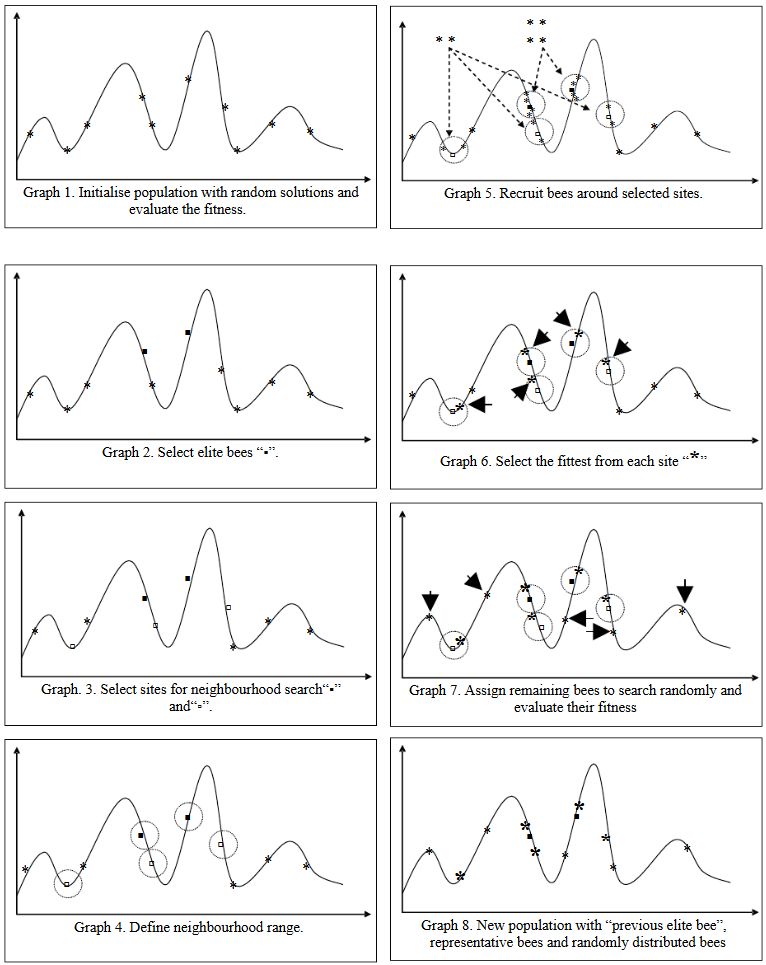

Условие окончания алгоритма – достижение заданного числа итераций.

При выборе параметров (S, B, G, b, g) следут соблюдать некоторые рекомендации:

Размер популяции S следует выбирать эмперически, это один из важных параметров алгоритма, от него зависит скорость поиска. При малой популяции поиск будет происходить медленно. Слишком большой объем популяции также замедлит поиск из-за большого числа вычислений на каждой итерации, поэтому для каждой задачи должно существовать какое-то оптимальное значение S.
 
В – значение лучших участков – не сильно влияет на производительность алгоритма, поэтому можно выбрать любое число больше 1.

Величина S – B – G – характеризует число случайных точек на каждой итерации, это значение не должно быть слишком маленьким.

# Реализация BA

In [4]:
from sympy import *
import random
import numpy as np
from sympy.plotting.plot import plot_contour

#### Генерация начальной популяции случайных точек в заданном диапазоне.

Входные параметры:

`S_numb` – количество точек.

`range_x` – границы по оси x.

`range_y` – границы по оси y.

Выход:

Список случайных точек в формате `[[x1, y1], [x2, y2], ...]`.

In [5]:
def random_points(S_numb, range_x, range_y):
  S = []
  for start_points in range(S_numb):
    start_points = [[random.uniform(range_x[0], range_x[1]), random.uniform(range_y[0], range_y[1])]]
    S.extend(start_points)
  return S

#### Вычисление значений целевой функции в заданных точках.

Входные параметры:

`S` – список точек.

`f` – целевая функция.

Выход:

Список значений функции в каждой точке.

In [6]:
def function_in_points(S, f):
  fx = []
  for start_points in range(len(S)):
    result = f.subs({x: S[start_points][0], y: S[start_points][1]}).evalf()
    fx.append(result)
  return fx

#### Разбиение точек на две группы B (лучшие точки) и G (хорошие точки, но не лучшие).

Входные параметры:

`arr` – список значений функции.

`points` – список точек.

`nb` – количество точек в группе `B`.

`ng` – количество точек в группе `G`.

Выход:

Два списка: `B` – лучшие точки, `G` – хорошие точки.

In [8]:
def n_min_indices_sorted(arr, points, nb, ng):
  B = []
  G = []
  arr = np.array(arr)

  #формирование группы B
  indices = np.argpartition(arr, nb)[:nb] #выбирает лучшие элменты до nb
  indices = indices[np.argsort(arr[indices])]
  for min in indices:
    B.extend([points[min]])

  #формирование группы G
  indices = np.argpartition(arr, nb)[nb:nb+ng] #выбирает лучшие элменты от nb до ng
  indices = indices[np.argsort(arr[indices])]
  for min in indices:
    G.extend([points[min]])

  return B, G

#### Генерация случайной точки внутри круга заданного радиуса.

Входные параметры:

`center_x`, `center_y` – координаты центра круга.

`radius` – радиус круга.

Выход:

Случайная точка `[x, y]` внутри круга.

In [9]:
def rand_point_in_circle(center_x=0, center_y=0, radius=1):
  theta = random.random() * 2 * pi
  r = sqrt(random.random()) * radius
  x = center_x + r * cos(theta)
  y = center_y + r * sin(theta)
  return [x.evalf(), y.evalf()]

#### Генерация окрестностей вокруг заданных точек.

Входные параметры:

`arr` – список базовых точек.

`num_points` – количество точек в каждой окрестности.

`radius` – радиус окрестности.

Выход:

Многомерный массив с точками, представляющий окрестности в формате `[[[x1, y1], [x2, y2]], ...]`.

In [14]:
def neighborhood_points(arr, num_points, radius=1):
  c = []
  for bounds in arr:
    inner_array = [rand_point_in_circle(bounds[0], bounds[1], radius) for _ in range(num_points)]
    inner_array.append(bounds)
    c.append(inner_array)
  return c

#### Алгоритм BA.

Входные параметры:

`f` – целевая функция.

`num_cycles` – количество итераций алгоритма.

`S_numb` – количество пчел (начальных точек).

`range_x`, `range_y`– диапазоны поиска.

`nb`, `ng` – размеры групп `B` и `G`.

`R` – начальный радиус окрестностей. 

С каждой популяцией `radius` окрестности уменьшается по следующей формуле: $ radius =  R \cdot e^{-i \cdot T} $

Где: $R$ - начальное значение радиуса, $T$ - коэффициент уменьшения радиуса, $i$ - номер цикла.

In [ ]:
def main(f, num_cycles, S_numb, R, range_x, range_y, nb, ng):
  S_new = random_points(S_numb, range_x, range_y) #Первая популяция из случайных значений
  cycle = 0

  while cycle < num_cycles:
    radius = R * exp(-cycle * 0.05) #Уменьшающийся радиус окрестности
    S = S_new
    fx = function_in_points(S, f)
    B, G = n_min_indices_sorted(fx, S, nb, ng)

    #Показ лучшей точки
    if not cycle % 10:
      W = function_in_points(B, f)
      W = np.array(W)
      min_index = np.argmin(W)
      B_min = B[min_index]
      print(cycle, B_min)
      #B_plot.extend([B_min])

    b = neighborhood_points(B, 3, radius)
    g = neighborhood_points(G, 5, radius)

    #Формирование новой популяции
    S_new = []

    #Выбор лучших точек из массива b
    for points in b:
        arr = function_in_points(points, f)
        arr = np.array(arr)
        min_index = np.argmin(arr)
        S_new.append(points[min_index])

    #Выбор лучших точек из массива g
    for points in g:
        arr = function_in_points(points, f)
        arr = np.array(arr)
        min_index = np.argmin(arr)
        S_new.append(points[min_index])

    #Добавление случайных точек до размера начальной популяции
    S_new.extend(random_points(len(S) - len(B) - len(G), range_x, range_y))
    cycle += 1
  return S_new

# Решение оптимизационной задачи

## Нахождение минимума функции `f1`

0 [-1.8451286262855815, 0.2301288950959579]
10 [-0.0579327429855962, -0.0469842479422804]
20 [0.0189282634992933, -0.0383069081917323]
30 [0.0189282634992933, -0.0383069081917323]
40 [0.0160569158278349, -0.00783863183637432]
50 [0.0133516713719301, 0.000196286942623400]
60 [0.000674836079114074, -0.0108452257609697]
70 [0.00582258227872682, -0.00373070654969286]
80 [-0.00202651515291713, 0.000813133320341914]
90 [0.00126393863642156, 0.000584364120072686]
100 [-0.000126777169713531, 0.000482963352093020]
110 [-0.000126777169713531, 0.000482963352093020]
120 [-0.000165996206649210, -0.000374555919434869]
130 [-0.000102744734229546, 0.000120442028073206]
140 [5.69097484249226e-5, -7.99969620483561e-7]
150 [5.69097484249226e-5, -7.99969620483561e-7]
160 [2.12816576067669e-5, 2.05743251335584e-5]
170 [2.12816576067669e-5, 2.05743251335584e-5]
180 [1.50114750038014e-5, 2.14020711060370e-5]
190 [6.43644244694026e-6, -5.35474669720674e-6]
Финальная популяция: [[6.43644244694026e-6, -5.354746

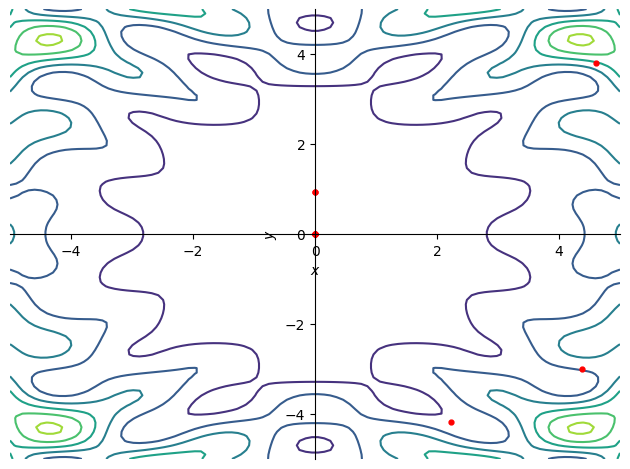

In [28]:
eps = 0.001 #ТОЧНОСТЬ
S_numb = 10 #КОЛИЧЕСТВО ПЧЕЛ
range_x, range_y = [-5, 5], [-5, 5] #ОКРЕСТНОСТЬ
R = 2 #НАЧАЛЬНЫЙ РАДИУС
num_cycles = 200  #КОЛИЧЕСТВО ЦИКЛОВ
nb = int(S_numb * 0.2) #КООЛИЧЕСТВО ТОЧЕК ДЛЯ ГРУППЫ B
ng = int(S_numb * 0.5) #КООЛИЧЕСТВО ТОЧЕК ДЛЯ ГРУППЫ G

x, y = symbols('x y') #создаем символьные переменные
f1 = 0.5*(x**2 + y**2)*(1.6 + 0.8*cos(1.5*x)*cos(3.14*y) + 0.8*cos(sqrt(5)*x)*cos(3.5*y)) #Целевая функция

S_new = main(f1, num_cycles, S_numb, R, range_x, range_y, nb, ng)
print(f'Финальная популяция: {S_new}')

#Построение графика
p=plot_contour(f1, (x, range_x[0], range_x[1]), (y, range_y[0], range_y[1]), markers = [{'args': [S_new[i][0], S_new[i][1]], 'color': "red", 'marker': ".", 'ms': 7} for i in range(len(S_new))])

Полученные точки минимума $ x = 6.436\cdot 10^{-6}, y = -5.355\cdot 10^{-6}$ удовлетворяет условию минимума в заданной точке $[0, 0]$ с точностью $\epsilon = 0.001$ по каждой координате.

## Нахождение минимума функции `f2`

0 [7.79884116183997, 4.0858037670895]
10 [1.38677757092102, 4.36874526848563]
20 [-1.28443655478717, -1.35286930664143]
30 [-1.35992241944755, -1.39862207989080]
40 [1.36249936273280, -1.35584364001179]
50 [-1.35412929141172, -1.35672506521376]
60 [-1.35637154553731, -1.35453235013789]
70 [1.34605091188295, -1.34502145305038]
80 [1.34588318519262, -1.34706289411638]
90 [-1.34800836576420, -1.34861161946366]
100 [1.35005628471966, -1.34971425928552]
110 [1.34927358336536, -1.34997348242090]
120 [-1.34949169731519, -1.34922332253776]
130 [-1.34949169731519, -1.34922332253776]
140 [1.34951150262164, 1.34940114045344]
150 [-1.34942751753641, -1.34942179250437]
160 [-1.34942751753641, -1.34942179250437]
170 [1.34942065898938, -1.34941027306359]
180 [-1.34940087725524, 1.34940170952607]
190 [-1.34940087725524, 1.34940170952607]
Финальная популяция: [[-1.34940538647507, -1.34940787263704], [1.34940316525117, 1.34941053613693], [-1.34940087725524, 1.34940170952607], [-1.34941581647512, -1.3494

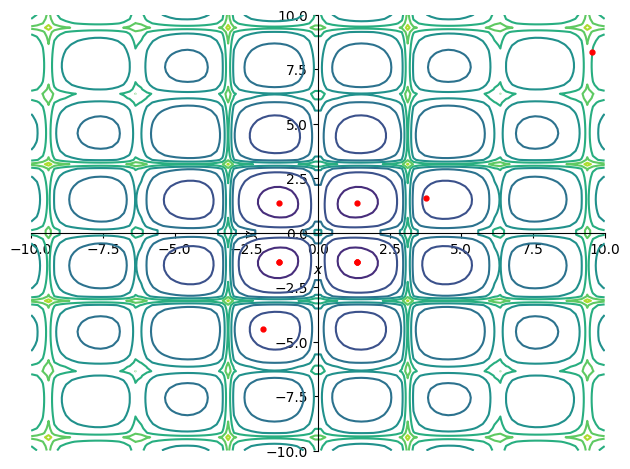

In [ ]:
eps = 0.001 #ТОЧНОСТЬ
S_numb = 10 #КОЛИЧЕСТВО ПЧЕЛ
range_x, range_y = [-10, 10], [-10, 10] #ОКРЕСТНОСТЬ
R = 2 #НАЧАЛЬНЫЙ РАДИУС
num_cycles = 200  #КОЛИЧЕСТВО ЦИКЛОВ
nb = int(S_numb * 0.2) #КООЛИЧЕСТВО ТОЧЕК ДЛЯ ГРУППЫ B
ng = int(S_numb * 0.5) #КООЛИЧЕСТВО ТОЧЕК ДЛЯ ГРУППЫ G

x, y = symbols('x y') #создаем символьные переменные
f2 = -0.0001*((abs(sin(x)*sin(y)*exp(100-((sqrt(x**2 + y**2))/(pi))))+1)**0.1) #Целевая функция

S_new = main(f2, num_cycles, S_numb, R, range_x, range_y, nb, ng)
print(f'Финальная популяция: {S_new}')

#Построение графика
p=plot_contour(f2, (x, range_x[0], range_x[1]), (y, range_y[0], range_y[1]), markers = [{'args': [S_new[i][0], S_new[i][1]], 'color': "red", 'marker': ".", 'ms': 7} for i in range(len(S_new))])

Полученные точки минимума $ x = \pm 1.3494, y = \pm 1.3494$ удовлетворяет условию минимума функции в точках $[\pm 1.3494, \pm 1.3494]$ с точностью $\epsilon = 0.001$ по каждой координате.